# Deep Learning &mdash; Assignment 3

Third assignment for the 2024 Deep Learning course (NWI-IMC070) of the Radboud University.

-----

**Names:** Andrew Schroeder and Fynn Gerding

**Group:** 17

-----

**Instructions:**
* Fill in your names and the name of your group.
* Answer the questions and complete the code where necessary.
* Keep your answers brief, one or two sentences is usually enough.
* Re-run the whole notebook before you submit your work.
* Save the notebook as a PDF and submit that in Brightspace together with the `.ipynb` notebook file.
* The easiest way to make a PDF of your notebook is via File > Print Preview and then use your browser's print option to print to PDF.

## Objectives

This assignment is a continuation of assignment 2. We will work on the same dataset with a similar network architecture.
In this assignment you will

1. Experiment with weight decay
2. Experiment with dropout
4. Experiment with early stopping

In [1]:
%config InlineBackend.figure_formats = ['png']
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import time
import torchvision
#import tqdm.notebook as tqdm
from tqdm import tqdm
import collections
import IPython
import pandas as pd

plt.style.use('ggplot')

# Fix the seed, so outputs are exactly reproducible
torch.manual_seed(12345);

# Use the GPU if available
def detect_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")
device = detect_device()

## 3.1 FashionMNIST again

We will work with the same code as last week, with some slight modifications.
So, we will again do experiments with the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). 

In [2]:
fashionmnist = torchvision.datasets.FashionMNIST(
    root=".", download=True,
    transform=torchvision.transforms.Compose([
         torchvision.transforms.ToTensor(),
         lambda img: img.flatten()
    ]))

# use 1000 samples for training, 500 for validation, ignore the rest
fashion_train, fashion_validation, _ = torch.utils.data.random_split(
    fashionmnist, [1000, 500, len(fashionmnist) - (1000 + 500)])

100%|██████████████████████████| 26421880/26421880 [00:03<00:00, 7755224.96it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|████████████████████████████████| 29515/29515 [00:00<00:00, 4072735.97it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




100%|████████████████████████████| 4422102/4422102 [00:00<00:00, 8991443.76it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████████████████████████████| 5148/5148 [00:00<00:00, 3338839.80it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



The neural network is the same as in assignment 2.
We include our implementation of `build_net` here. You may substitute your own implementation instead, if you prefer.

In [3]:
def build_net():
    return torch.nn.Sequential(
        torch.nn.Linear(784, 128),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10)
    )

The training code is also almost the same as last time, except that we add an extra parameter to `fit`.

In [4]:
def fit(net, train, validation, optimizer, epochs=25, batch_size=10, after_epoch=None, device=device):
    """
    Train and evaluate a network.
     - net:               the network to optimize
     - train, validation: the training and validation sets
     - optimizer:         the optimizer (such as torch.optim.SGD())
     - epochs:            the number of epochs to train
     - batch_size:        the batch size
     - after_epoch:       optional function to call after every epoch
     - device:            whether to use a gpu ('cuda') or the cpu ('cpu')
    
    Returns a dictionary of training and validation statistics.
    """

    # move the network parameters to the gpu, if necessary
    net = net.to(device)
    
    # initialize the loss and accuracy history
    history = collections.defaultdict(list)
    epoch_stats, phase = None, None

    # initialize the data loaders
    data_loader = {
        'train':      torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True),
        'validation': torch.utils.data.DataLoader(validation, batch_size=batch_size)
    }

    # measure the length of the experiment
    start_time = time.time()

    # some advanced PyTorch to look inside the network and log the outputs
    # you don't normally need this, but we use it here for our analysis
    def register_measure_hook(idx, module):
        def hook(module, input, output):
            with torch.no_grad():
                # store the mean output values
                epoch_stats['%s %d: %s output mean' % (phase, idx, type(module).__name__)] += \
                    output.mean().detach().cpu().numpy()
                # store the mean absolute output values
                epoch_stats['%s %d: %s output abs mean' % (phase, idx, type(module).__name__)] += \
                    output.abs().mean().detach().cpu().numpy()
                # store the std of the output values
                epoch_stats['%s %d: %s output std' % (phase, idx, type(module).__name__)] += \
                    output.std().detach().cpu().numpy()
        module.register_forward_hook(hook)

    # store the output for all layers in the network
    for layer_idx, layer in enumerate(net):
        register_measure_hook(layer_idx, layer)
    # end of the advanced PyTorch code
    
    for epoch in tqdm(range(epochs), desc='Epoch', leave=False):
        # initialize the loss and accuracy for this epoch
        epoch_stats = collections.defaultdict(float)
        epoch_stats['train steps'] = 0
        epoch_stats['validation steps'] = 0
        epoch_outputs = {'train': [], 'validation': []}

        # first train on training data, then evaluate on the validation data
        for phase in ('train', 'validation'):
            # switch between train and validation settings
            net.train(phase == 'train')

            epoch_steps = 0
            epoch_loss = 0
            epoch_accuracy = 0
            
            # loop over all minibatches
            for x, y in data_loader[phase]:
                # move data to gpu, if necessary
                x = x.to(device)
                y = y.to(device)

                # compute the forward pass through the network
                pred_y = net(x)

                # compute the current loss and accuracy
                loss = torch.nn.functional.cross_entropy(pred_y, y)
                pred_class = torch.argmax(pred_y, dim=1)
                accuracy = torch.mean((pred_class == y).float())

                # add to epoch loss and accuracy
                epoch_stats[f'{phase} loss'] += loss.detach().cpu().item()
                epoch_stats[f'{phase} accuracy'] += accuracy.detach().cpu().item()

                # store outputs for later analysis
                epoch_outputs[phase].append(pred_y.detach().cpu().numpy())

                # only update the network in the training phase
                if phase == 'train':
                    # set gradients to zero
                    optimizer.zero_grad()

                    # backpropagate the gradient through the network
                    loss.backward()

                    # track the gradient and weight of the first layer
                    # (not standard; we only need this for the assignment)
                    epoch_stats['train mean abs grad'] += \
                        torch.mean(torch.abs(net[0].weight.grad)).detach().cpu().item()
                    epoch_stats['train mean abs weight'] += \
                        torch.mean(torch.abs(net[0].weight)).detach().cpu().item()

                    # update the weights
                    optimizer.step()

                epoch_stats[f'{phase} steps'] += 1

            # compute the mean loss and accuracy over all minibatches
            for key in epoch_stats:
                if phase in key and not 'steps' in key:
                    epoch_stats[key] = epoch_stats[key] / epoch_stats[f'{phase} steps']
                    history[key].append(epoch_stats[key])

            # count the number of update steps
            history[f'{phase} steps'].append((epoch + 1) * epoch_stats[f'{phase} steps'])
            
            # store the outputs
            history[f'{phase} outputs'].append(np.concatenate(epoch_outputs[phase]).flatten())

        history['epochs'].append(epoch)
        history['time'].append(time.time() - start_time)

        # call the after_epoch function
        if after_epoch is not None:
            stop = after_epoch(net, epoch, epoch_stats)
            if stop is Stop:
                break

    return history

# marker to indicate stopping
Stop = "stop"

In [5]:
# helper code to plot our results
class HistoryPlotter:
    def __init__(self, plots, table, rows, cols, param_names=[]):
        self.plots = plots
        self.table = table
        self.rows = rows
        self.cols = cols
        self.histories = {}
        self.results = []
        self.params = []
        self.param_names = []
        
        self.fig, self.axs = plt.subplots(ncols=cols * len(plots), nrows=rows,
                                          sharex='col', sharey='none',
                                          figsize=(3.5 * cols * len(plots), 3 * rows))
        plt.tight_layout()
        IPython.display.display(self.fig)
        IPython.display.clear_output(wait=True)

    # add the results of an experiment to the plot
    def add(self, title, history, row, col, epoch=-1, param=None):
        self.histories[title] = history
        self.results.append((title, {key: history[key][epoch] for key in self.table}))
        self.params.append(param)
        
        for plot_idx, plot_xy in enumerate(self.plots):
            ax = self.axs[row, col * len(self.plots) + plot_idx]
            for key in plot_xy['y']:
                lines = ax.plot(history[plot_xy['x']], history[key], label=key)
                if epoch >= 0:
                    ax.plot([history[plot_xy['x']][epoch]], [history[key][epoch]], marker='*', color='black')
            if 'accuracy' in plot_xy['y'][0]:
                ax.set_ylim([0, 1.01])
            ax.legend()
            ax.set_xlabel(plot_xy['x'])
            ax.set_title(title)
        plt.tight_layout()
        IPython.display.clear_output(wait=True)
        IPython.display.display(self.fig)

    # print a table of the results for all experiments
    def print_table(self):
        df = pd.DataFrame([
            { 'experiment': title, **{key: row[key] for key in self.table} }
            for title, row in self.results
        ])
        IPython.display.display(df)

    def done(self):
        plt.close()
        self.print_table()

## 3.2 Weight decay (6 points)

The training can be regularized using weight decay. This option is built-in in many of the PyTorch optimizers [(documentation)](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam).

We will set up an experiment to investigate how this affects the training of the model.

We use the good settings from last week:
* Optimizer: Adam
* Learning rate: 0.0001
* Minibatch size: 32
* 150 epochs

and apply L2 weight decay with a factor 0, 0.0001, 0.001, 0.01, or 0.1.

**(a) Complete the code below and run the experiment. <span style="float:right"> (1 point)</span>**

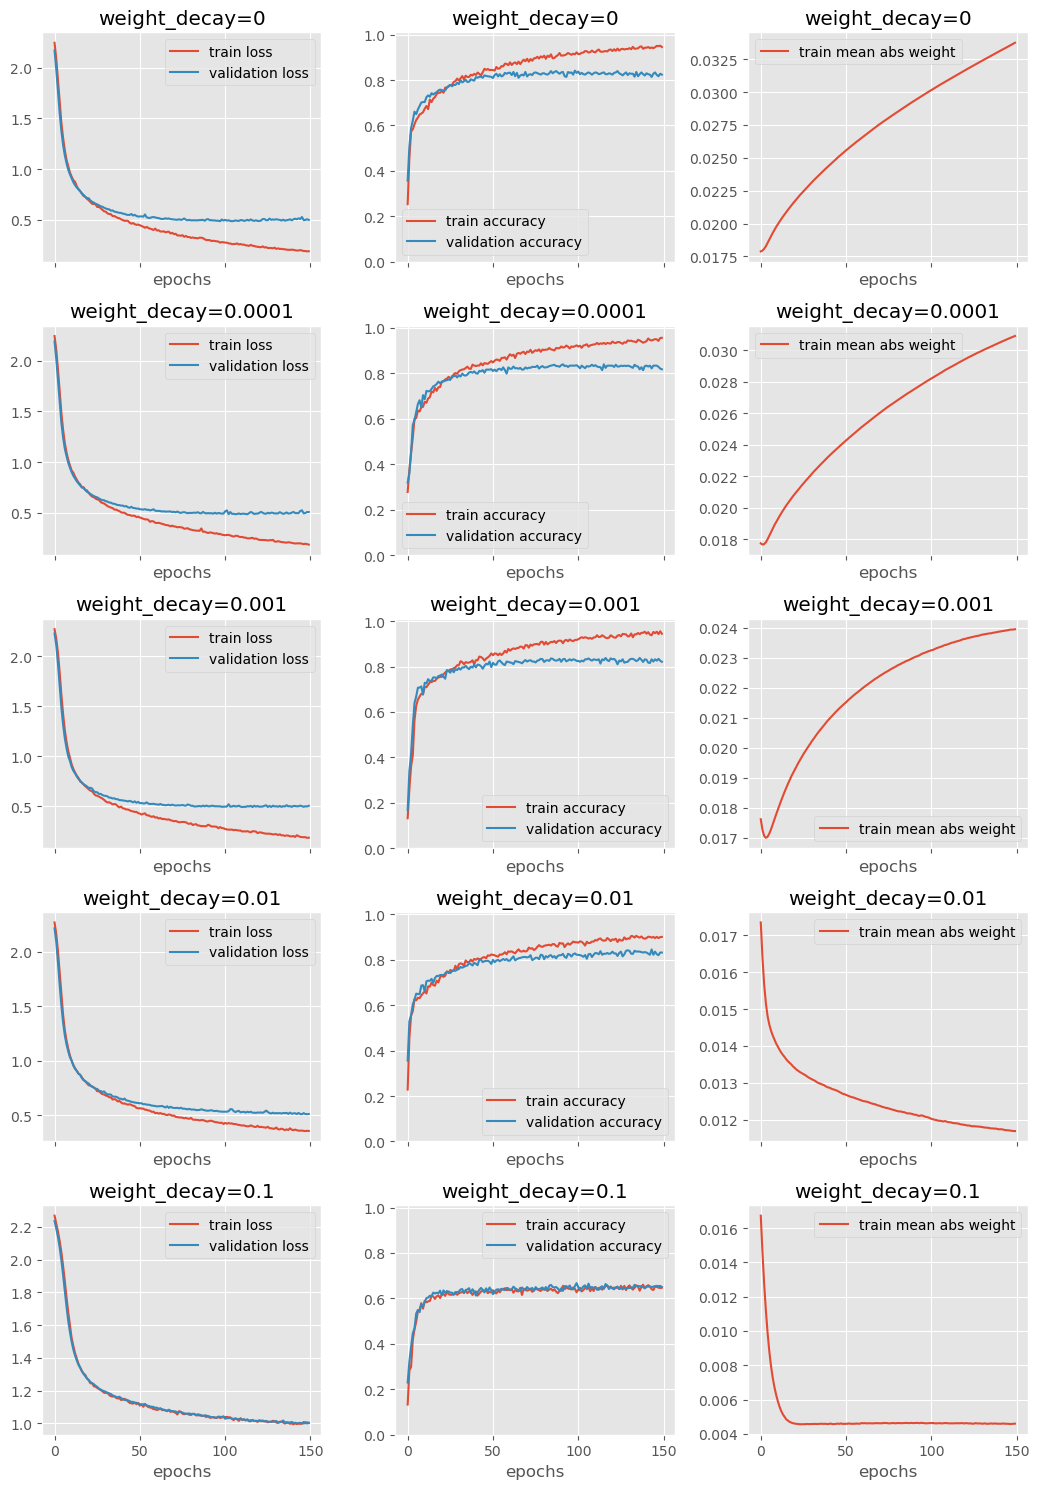

,experiment,train accuracy,validation accuracy,train mean abs weight
0,weight_decay=0,0.945312,0.823828,0.033752
1,weight_decay=0.0001,0.956055,0.817578,0.030919
2,weight_decay=0.001,0.944336,0.820703,0.023954
3,weight_decay=0.01,0.900391,0.831641,0.011700
4,weight_decay=0.1,0.647461,0.650000,0.004591


In [6]:
plotter_weight_decay = \
    HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                          {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']},
                          {'x': 'epochs', 'y': ['train mean abs weight']},],
                   table=['train accuracy', 'validation accuracy', 'train mean abs weight'],
                   param_names=['weight_decay'],
                   rows=5, cols=1)

epochs = 150
lr = 0.0001
batch_size = 32
weight_decays = [0, 0.0001, 0.001, 0.01, 0.1]

for row, weight_decay in enumerate(weight_decays):
    net = build_net()
    # TODO: Set up optimizer with the given weight_decay
    optimizer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)
    history_weight_decay = fit(net, fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
    plotter_weight_decay.add(f'weight_decay={weight_decay}', history_weight_decay, row=row, col=0, param=weight_decay)

plotter_weight_decay.done()

**(b) How can you observe the amount of overfitting in the plots? <span style="float:right"> (1 point)</span>**

The level of overfitting can be determined by the difference in the train and validation accuracy. Typically when a model is overfitting, the train accuracy is very high but the validation accuracy is low since models that overfit on training data do not generalize well to unseen data. We can also do a similar analysis on the loss curves - if the validation loss is above the training loss then this may be an indication we are overfitting.

**(c) How does weight decay affect the performance of the model in the above experiments? Give an explanation in terms of the amount of overfitting. <span style="float:right"> (1 point)</span>**

For `weight_decay = 0`, we see that the model is overfitting on the training set and the mean absolute weight value increases with higher epoch numbers. As we increase the weight decay to 0.001, we see that the curves for validation and training are more aligned in both the accuracy and loss plots, indicating less overfitting. We also see that with `weight_decay=0.01` that the mean weight values decrease as the number of epochs increase. As we increase the weight decay to 0.1 we can begin to see examples of *underfitting* - the train and validation curves align, but the accuracy drops from 80% to ~60%, indicating that the model is struggling to learn from the training data with the large penalties for weights.

In these experiments you have implemented weight decay using the built in weight decay feature of the optimizer.

An alternative is to add an L2 penaltiy to the loss:
\begin{align*}
L_\text{regularized}(\theta) = L(\theta) + \lambda \frac{1}{2} |\theta|_2^2,
\end{align*}
which results in a gradient
\begin{align*}
\nabla_\theta L_\text{regularized}(\theta) = \nabla_\theta L(\theta) + \lambda \theta.
\end{align*}
Using gradient descend will then decrease the weights.

**(d) Are the two ways of implementing weight decay equivalent when using the Adam optimizer? <span style="float:right"> (1 point)</span>**

Hint: look at [the torch documentation for Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html).

According to the documentation these two implementations are equivalent since under the hood Pytorch uses the L2 penalty for applying weight decay. 

`weight_decay (float, optional) – weight decay (L2 penalty) (default: 0)`

Another way to implement weight decay, and where the name comes from, is to scale or decay the weights directly:
\begin{align*}
\theta \gets (1 - \lambda) \theta
\end{align*}

Combined with Adam, this gives the [`AdamW` optimizer](https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html).

**(e) Are Adam and AdamW equivalent? Explain your answer. <span style="float:right"> (1 point)</span>**

According to the linked paper in the documentation for AdamW [Decoupled Weight Decay Regularization](https://arxiv.org/abs/1711.05101), L2 regularization and weight decay regularization are essentially equivalent for standard SGD methods, but are not the same for adaptive gradient descent algorithms, such as Adam. AdamW decouples the weight decay from the optimization step taken w.r.t the loss function. This means that in AdamW, we have decoupled the setting of the optimal weight decay factor from the setting of the learning rate, which standard Adam does not do.

### Learning curves

So far the only learning curves we have looked at have the number of epochs on the horizontal axis. We can also make learning curves putting another parameter on that axis.

**(f) Run the code below to plot a learning curve <span style="float:right"> (no points)</span>**

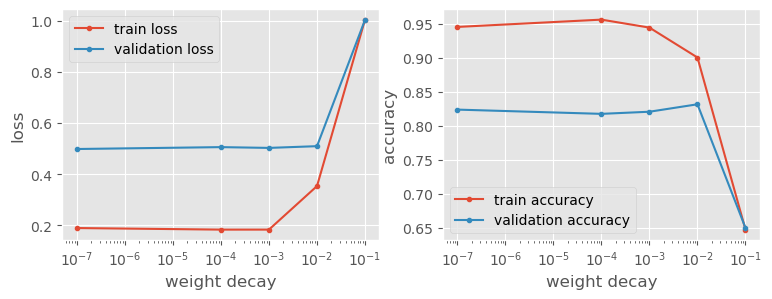

In [7]:
weight_decays = torch.tensor(plotter_weight_decay.params) + 1e-7
  # Note: add 1e-7 to prevent log(0)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(4.5 * 2, 3))
for i, stat in enumerate(['loss', 'accuracy']):
    keys = [f'train {stat}', f'validation {stat}']
    values = {key: [r[1][key][-1] for r in plotter_weight_decay.histories.items()] for key in keys}

    ax = axs[i]
    for key in keys:
        ax.plot(weight_decays, values[key], '.-', label=key)
    ax.set_xscale('log');
    ax.set_xlabel('weight decay');
    ax.set_ylabel(stat);
    ax.legend();

**(g) Looking a this learning curve, how do you see signs of overfitting or underfitting? <span style="float:right"> (1 point)</span>**

In the left plot we see loss vs weight decay and it appears we are overfitting when the weight is in the range $[10^{-7}, 10^{-3}]$ since the validation loss is higher than the training loss. At $10^{-1}$ we can see that the train and validation loss are both the same but have spiked to a loss of 1.0, indicating that the model is struggling to learn and that we are underfitting. A similar analysis applies to the accuracy plot on the right. It seems the optimal weight decay is somehwere around $10^{-2}$.

## 3.3 Dropout (9 points)

Next, we will do experiments with dropout. This gives another way of regularizing the training.

**(a) Make a copy of the network architecture below, and add dropout.<span style="float:right"> (1 point)</span>**

Add dropout layers after each linear layer, except for the last.

Hint: see [torch.nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

In [8]:
def build_net_with_dropout(p):
    return torch.nn.Sequential(
        torch.nn.Linear(784, 128),
        torch.nn.Dropout(p),
        torch.nn.ReLU(),
        torch.nn.Linear(128, 64),
        torch.nn.Dropout(p),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10)
    )

**(b) Should you put dropout layers before or after ReLU activation functions? Does it matter?<span style="float:right"> (1 point)</span>**

Specifically with the ReLU activation function the order does not seem to matter as Dense > ReLU > Dropout would produce the same output as Dense > Dropout > RelU.

**(c) What would happen if you put a dropout layer after the last linear layer?<span style="float:right"> (1 point)</span>**

The last layer is reponsible for producing the logits that define the unormalized probabilitities of a particular input image being in each of the 10 classes. It wouldn't make sense to put a dropout layer after the last linear layer as we would be randomly setting the logits for each class to 0 which would not help regularize the network. Also we would lose important gradient information and wouldn't be able to effectively backpropogate some gradients through the network to learn if the outputs were randomly set to zero. 

**(d) Set up an experiment to see how dropout affects our results. <span style="float:right"> (1 point)</span>**

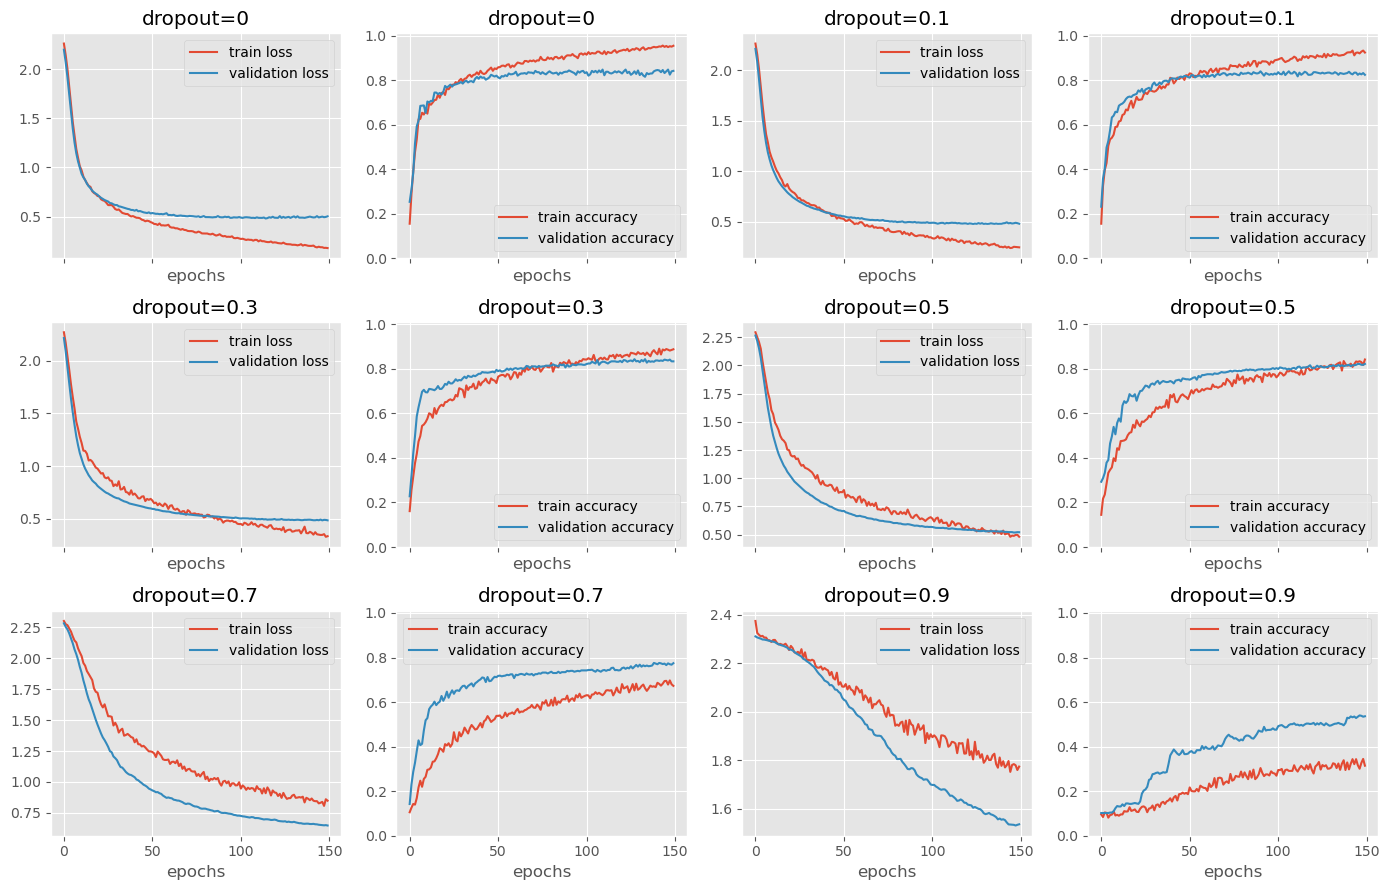

,experiment,train accuracy,validation accuracy,train mean abs weight
0,dropout=0,0.954102,0.841406,0.034070
1,dropout=0.1,0.923828,0.823828,0.032223
2,dropout=0.3,0.887695,0.833594,0.029244
3,dropout=0.5,0.841797,0.821875,0.027197
4,dropout=0.7,0.672852,0.774609,0.023895
5,dropout=0.9,0.314453,0.536328,0.018973


In [9]:
plotter_dropout = \
    HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                          {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']},],
                   table=['train accuracy', 'validation accuracy', 'train mean abs weight'],
                   param_names=['dropout'],
                   rows=3, cols=2)

epochs = 150
lr = 0.0001
batch_size = 32
dropouts = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

for row, dropout in enumerate(dropouts):
    # TODO: Set up a network with the right dropout, and an optimizer
    net = build_net_with_dropout(dropout)
    optimizer = torch.optim.Adam(net.parameters(), lr)
    history_dropout = fit(net, fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size)
    plotter_dropout.add(f'dropout={dropout}', history_dropout, row=row//2, col=row%2, param=dropout)

plotter_dropout.done()

**(e) How does dropout affect the results?<span style="float:right"> (1 point)</span>**

With zero dropout we can see indications of overfitting, however as we increase the dropout rate the train and validation curves begin to align more closely which is ideal. If we increase dropout beyond this point $p>0.5$ we begin to see indications of underfitting, where the train loss is higher than the validation loss and the train acccuracy is lower than the validation accuracy.

**(f) How does dropout affect training speed? Has the training converged in all runs?<span style="float:right"> (1 point)</span>**

It seems that as the dropout rate increases, training takes longer. It seems that most runs have not converged, as the training loss is still going down in most plots and has not hit a lower bound. Similarly, training accurcy has not plateaued in most of the plots. 

**(g) With a large amount of dropout, the training loss can be worse than the validation loss. How is this possible?<span style="float:right"> (1 point)</span>**

This is possible because for high levels of dropout, many neurons are inactive during training, resulting in a large training loss because the network has difficulty learning with fewer neurons. During validation however, dropout is not applied and all neurons are active, meaning that the network performs better.

**(h) Plot a learning curve for the dropout parameter<span style="float:right"> (1 point)</span>**

You should use a linear scale for the x-axis. Be sure to use the right histories, and to label your axes.

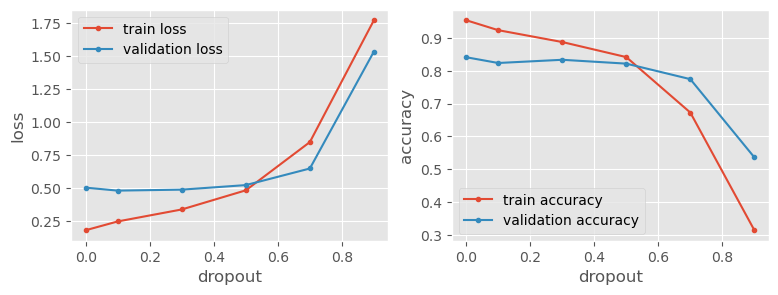

In [10]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(4.5 * 2, 3))
for i, stat in enumerate(['loss', 'accuracy']):
    keys = [f'train {stat}', f'validation {stat}']
    values = {key: [r[1][key][-1] for r in plotter_dropout.histories.items()] for key in keys}

    ax = axs[i]
    for key in keys:
        ax.plot(dropouts, values[key], '.-', label=key)
    ax.set_xscale('linear');
    ax.set_xlabel('dropout');
    ax.set_ylabel(stat);
    ax.legend();

**(i) Does the above learning curve show a clear optimum?<span style="float:right"> (1 point)</span>**

It would appear the clear optimum value is at the intersection of the validation and train curves - with dropout about 0.5.

## 3.4 Early stopping (7 points)

If you look at the learning curves of the unregularised models, you can see that the validation loss starts to go up after a certain amount of training.
It would be good to stop at that point, which is called early stopping.

There are two ways to implement early stopping:
1. Run the training for a fixed number of epochs, but keep track of the best result on the validation set.
2. Run until the validation loss does not decrease for a certain number of epochs.

Only the second option is actually early *stopping*, but the first option can be easier to implement.

**(a) Implement the first style of early stopping, and run the experiment below. <span style="float:right"> (2 points)</span>**

You can pass a function to the `after_epoch` parameter of `fit`. This function is called after every epoch.

The `epoch` parameter to `plotter.add` highlights a specific epoch in the results with a star, and selects it for the table.

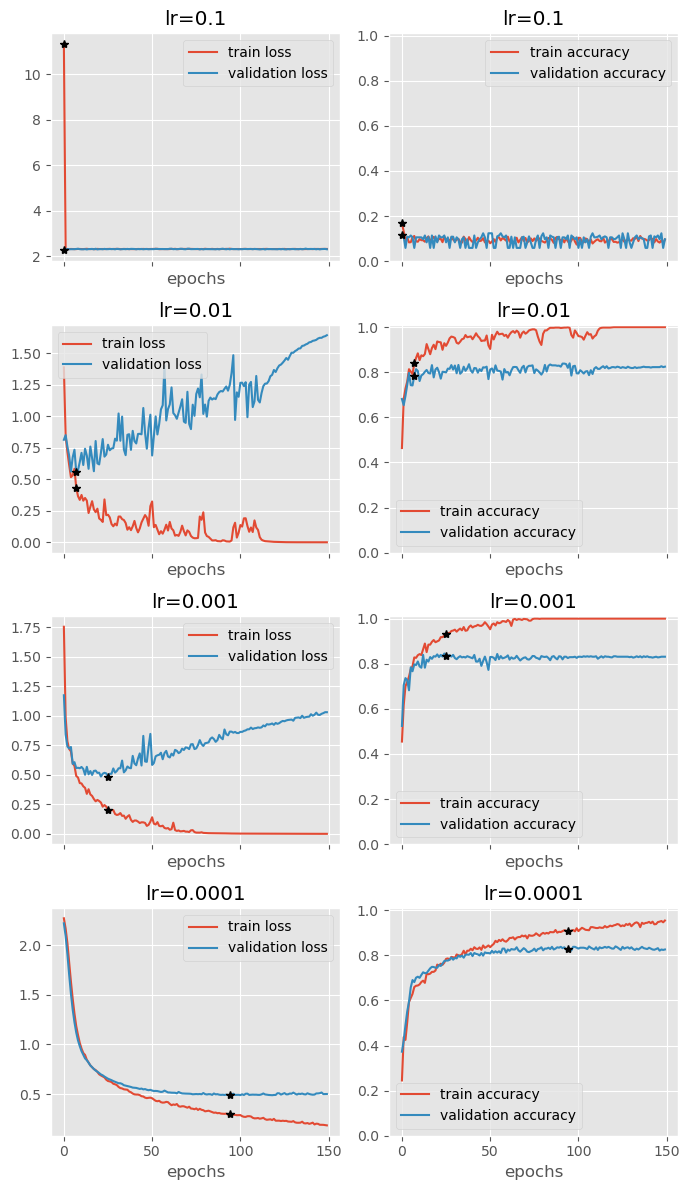

,experiment,train loss,validation loss,train accuracy,validation accuracy,epochs
0,lr=0.1,11.341012,2.256727,0.168945,0.113672,0
1,lr=0.01,0.434449,0.559644,0.838867,0.783594,7
2,lr=0.001,0.205554,0.486400,0.932617,0.833594,25
3,lr=0.0001,0.304239,0.488490,0.907227,0.829688,94


In [13]:
import copy

plotter_early_stop = \
    HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                          {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']}],
                   table=['train loss', 'validation loss', 'train accuracy', 'validation accuracy', 'epochs'],
                   rows=4, cols=1)

epochs = 150
lr = 0.001
lrs = [0.1, 0.01, 0.001, 0.0001]
batch_size = 32

for row, lr in enumerate(lrs):
    # the best network, epoch at which we found it, and stats 
    best_net = None
    best_epoch = 0
    best_stats = {'train loss': torch.inf, 'validation loss': torch.inf, 'train accuracy': 0, 'validation accuracy': 0}

    def track_best(net, epoch, epoch_stats):
        global best_net, best_epoch, best_stats
        if epoch_stats['validation loss'] < best_stats['validation loss']:
            best_net = copy.deepcopy(net)
            best_epoch = epoch
            best_stats = epoch_stats.copy()

    net = build_net()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    history_early_stop = fit(net, fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size, after_epoch=track_best)
    plotter_early_stop.add(f'lr={lr}', history_early_stop, row=row, col=0, epoch=best_epoch)

plotter_early_stop.done()

**(b) Looking at the results, does early stopping prevent overfitting?<span style="float:right"> (1 point)</span>**

In the case where `lr=0.1` there was practically no learning at all, so also early stopping could not help. In the runs where `lr=0.01` and `lr= 0.001`, early stopping would make a big difference. For very low learning rates like `0.0001`, early stopping doesn't seem to have a large effect again, as the model only changes so graudally that overfitting does not seem to be an issue (mostely).

**(c) Is it fair to compare the validation loss you get with early stopping to the loss without early stopping? Briefly explain your answer.<span style="float:right"> (1 point)</span>**

Not exactly, as the validation loss was the requirement to initiate early stopping, therefore any score obtained in an early stopping scenario is by definition chery-picked.

Copying a neural network with `net2 = net1` makes a shallow copy, that is, the two variables refer to the same network in memory.

**(d) If you used `best_net = net` in `track_best`, would `best_net` contain the optimal early stopping parameters after training? If not, how could you get access to them?<span style="float:right"> (1 point)</span>**

If one would use `best_net = net`, `best_net` would simply be a memory pointer that would point to the model that is updated with every backwards pass. For an actual copy of the parameters, one would need to use something like `best_net = copy.deepcopy(net)`.

### Actual early *stopping*

It is wasteful to keep training if we know that the loss is only getting worse. So we might as well stop at that point.

**(e) Implement the second variant of early stopping: stop training if the validation loss does not decrease for 5 epochs.<span style="float:right"> (1 point)</span>**

Hint: The `fit` function will stop the training if the `after_epoch` function returns `Stop`.

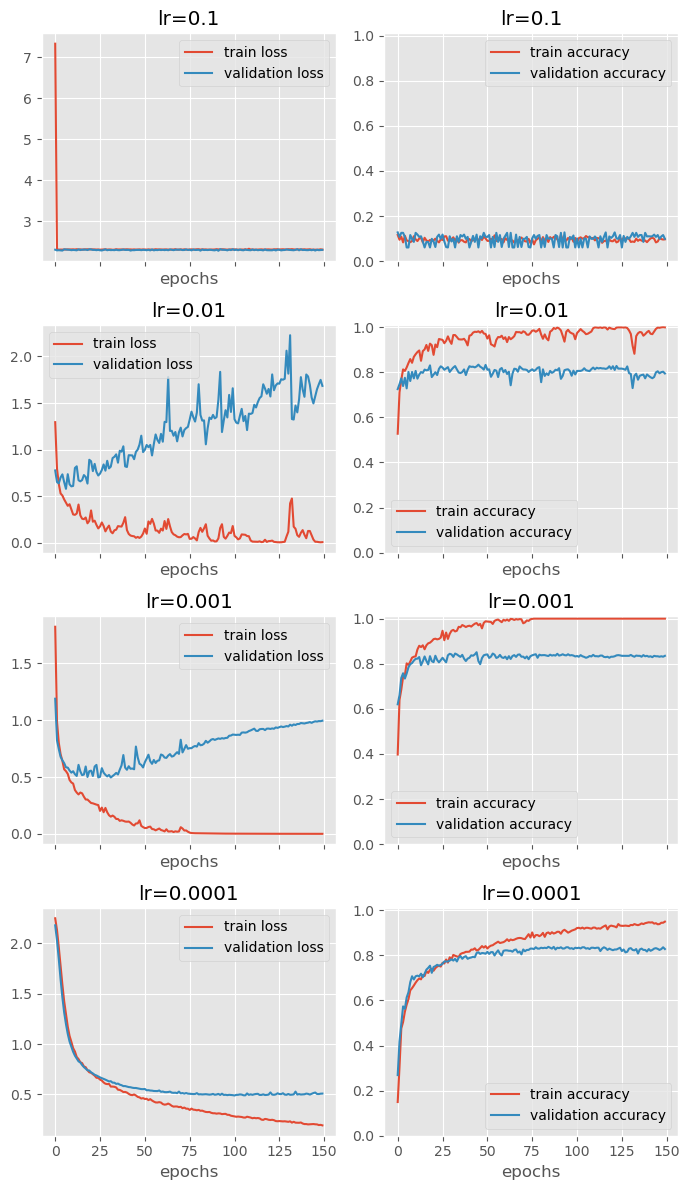

,experiment,train loss,validation loss,train accuracy,validation accuracy,epochs
0,lr=0.1,2.312664,2.306514,0.096680,0.098828,149
1,lr=0.01,0.004447,1.683911,0.999023,0.794531,149
2,lr=0.001,0.000456,0.994927,1.000000,0.835156,149
3,lr=0.0001,0.190706,0.506758,0.949219,0.827734,149


In [18]:
plotter_early_stop2 = \
    HistoryPlotter(plots=[{'x': 'epochs', 'y': ['train loss', 'validation loss']},
                          {'x': 'epochs', 'y': ['train accuracy', 'validation accuracy']}],
                   table=['train loss', 'validation loss', 'train accuracy', 'validation accuracy', 'epochs'],
                   rows=4, cols=1)

epochs = 150
lr = 0.001
lrs = [0.1, 0.01, 0.001, 0.0001]
batch_size = 32

for row, lr in enumerate(lrs):
    best_net = None
    best_epoch = 0
    best_stats = {'train loss': torch.inf, 'validation loss': torch.inf, 'train accuracy': 0, 'validation accuracy': 0}
    no_improvement_epochs = 0
    def stop_if_no_loss_decrease(net, epoch, epoch_stats):
        global best_net, best_epoch, best_stats, no_improvement_epochs
        # TODO: return Stop if the loss does not go down for 5 epochs
        if epoch_stats['validation loss'] < best_stats['validation loss']:
            best_net = copy.deepcopy(net)
            best_epoch = epoch
            best_stats = epoch_stats.copy()
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1

        if no_improvement_epochs >= 5:
            return 'Stop'

    net = build_net()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    history_early_stop2 = fit(net, fashion_train, fashion_validation, optimizer=optimizer, epochs=epochs, batch_size=batch_size, after_epoch=stop_if_no_loss_decrease)
    plotter_early_stop2.add(f'lr={lr}', history_early_stop2, row=row, col=0)

plotter_early_stop2.done()

**(f) With the second variant of early stopping, is the network after training the optimal one? <span style="float:right"> (1 point)</span>**

As there is now a manually set threshold of `5` epochs without improvement, there is a risk that the network stopped _too_ early and the last `5` epochs were just 'unlucky'.

## 3.5 Hyperparameter optimization (3 points)

We have seen quite a few hyperparameters this week and last week.
To pick the optimal parameters, one strategy would be to do what we have done, and run an experiment for each parameter individually.

**(a) Look at the previous experiments, and pick the best hyperparameter values.<span style="float:right"> (1 point)</span>**

Optionally: look at the experiments from assignment 2 and also pick the optimal network width.

Batch size:    32  
Optimizer:     Adam  
Learning rate: 0.001  
Dropout:       0  
Weight decay:  0.01  

**(b) If you select the hyperparameters this way, will you get the best results? Explain your answer.<span style="float:right"> (1 point)</span>**

While we did sweep over a reasonable range individually, not all interactions between the variables has been tested. Therefore, conclusions are very limited. To be more certain, a grid-search, random-search or more advanced technique like bayesian optimisation would need to be used that respect combinations of parameters and their interactions.

An alternative is to use a grid search, and try all possible combinations of hyperparameters.

**(c) How many experiments would you need to do to explore all combinations of learning rate, weight decay, and dropout that we used in this assignment?<span style="float:right"> (1 point)</span>**

lr:           4 options
weight_decay: 5 options
dropout:      6 options

total options: 4*5*6 = 120 options

## The end

Well done! Please double check the instructions at the top before you submit your results.

*This assignment has 25 points.*
<span style="float:right;color:#aaa;font-size:10px;"> Version 9571342 / 2024-09-18</span>